# **어텐션을 사용한 인공 신경망 기계 번역**

이 연습은 스페인어를 영어로 변역하기 위해 시퀀스-투-시퀀스 (seq2seq) 모델을 훈련시킨다. 또한 이 연습은 시퀀스-투-시퀀스 모델의 사전적인 지식을 요구하는 심화된 예제이다.

이 노트북에서 신경망 기계 번역 모델을 훈련하면 *"¿todavia estan en casa?"* 와 같은 스페인 문장을 입력했을 때 *"are you still at home?"* 처럼 영어로 번역된 문장을 얻는다.

번역의 질은 간단한 예제로는 타당하지만 시각화된 어텐션 플롯은 아마 더 흥미로울 것이다. 아래의 플롯은 모델을 훈련하는 동안에 입력 문장의 각 단어가 갖고 있는 모델 어텐션을 시각화하여 보여준다:

<img src='https://tensorflow.org/images/spanish-english.png' alt='spanish-english attention plot'>

노트: 이 예제를 단일 P100 GPU에서 실행하기 위해서는 약 10분 정도 걸린다.

## **데이터셋 다운로드하고 준비하기**

http://www.manythings.org/anki/ 에서 제공한 언어 데이터셋을 사용한다. 이 데이터셋은 언어 번역의 쌍이 다음과 같은 형식으로 포함된다:

```
May I borrow this book?	¿Puedo tomar prestado este libro?
```

다양한 언어가 이용 가능하지만 이 예제에서는 영어-스페인 데이터셋을 사용한다. 편의를 위해서 이 데이터셋의 복사본을 Google Cloud에서 호스팅 했지만 직접 다운로드해야 한다. 데이터셋을 다운로드한 후에 데이터를 준비하고자 다음의 단계를 수행한다.

1. 각 문장에 *start*와 *end* 토큰을 추가한다.
2. 특정 문자를 제거함으로써 문장을 정리한다.
3. 단어 인덱스와 아이디(ID) 인덱스를 생성한다. (단어 → 아이디(ID), 아이디(ID) → 단어로 매핑된 딕셔너리).
4. 각 문장을 입력층의 최대 길이만큼 패딩(padding)을 수행한다.

In [1]:
import tensorflow as tf
import os

# 파일을 다운로드한다.
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', 'http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip', extract=True
)
path_to_file = os.path.dirname(path_to_zip) + '/spa-eng/spa.txt'

In [2]:
import unicodedata
import re


# 유니코드 파일을 아스키 코드 파일로 변환한다.
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower())
    # 단어와 단어 뒤에 오는 구두점(.)사이에 공백을 생성한다.
    # 예시: 'he is a boy.' => 'he is a boy . '
    # 참고: https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r'([?.!,¿])', r' \1 ', w)
    # (a-z, '.', '?', '!', ',')을 제외한 모든 것을 공백으로 대체한다.
    w = re.sub(r'[^a-z?.!,¿]+', ' ', w)
    w = w.strip()
    # 모델이 예측을 시작하거나 중단할 때를 알게 하기 위해서 문장에 start와 end 토큰을 추가한다.
    w = '<start> ' + w + ' <end>'
    return w

In [3]:
en_sentence = 'May I borrow-this book?'
sp_sentence = '¿Puedo tomar prestado este libro?'
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [4]:
import io


# 1. 문장에 있는 억양을 제거한다.
# 2. 불필요한 문자를 제거하여 문장을 정리한다.
# 3. 다음과 같은 형식으로 문장의 쌍을 반환한다: [영어, 스페인어]
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')] for l in lines[:num_examples]]
    return zip(*word_pairs)

In [5]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [6]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.utils.pad_sequences(tensor, padding='post')
    return tensor, lang_tokenizer

In [7]:
def load_dataset(path, num_examples=None):
    # 전처리된 타겟 문장과 입력 문장 쌍을 생성한다.
    targ_lang, inp_lang = create_dataset(path, num_examples)
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### **더 빠른 실행을 위해 데이터셋의 크기 제한하기(선택)**

10만개 이상의 문장이 있는 완전한 데이터셋을 훈련하는 것은 오랜 시간이 걸린다. 훈련 속도를 높이기 위해서 데이터셋의 크기를 3만개의 문장으로 제한한다. (물론, 번역의 질은 데이터가 적어질수록 저하된다):

In [8]:
# 언어 데이터셋을 아래의 크기로 제한하여 훈련과 검증을 수행한다.
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)
# 타겟 텐서와 입력 텐서의 최대 길이를 계산한다.
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [9]:
from sklearn.model_selection import train_test_split

# 훈련 집합과 검증 집합을 80대 20으로 분리한다.
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(
    input_tensor, target_tensor, test_size=0.2
)
# 훈련 집합과 검증 집합의 데이터 크기를 출력한다.
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [10]:
def convert(lang, tensor):
    for t in tensor:
        if t != 0:
            print(f'{t} ----> {lang.index_word[t]}')

In [11]:
print('Input Language; index to word mapping')
convert(inp_lang, input_tensor_train[0])
print('\nTarget Language; index to word mapping')
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
11 ----> que
206 ----> alto
52 ----> eres
27 ----> !
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
52 ----> how
340 ----> tall
6 ----> you
24 ----> are
37 ----> !
2 ----> <end>


### **tf.data 데이터셋 생성하기**

In [12]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train) // BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index) + 1
vocab_tar_size = len(targ_lang.word_index) + 1
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, True)

In [13]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

## 인코더 모델과 디코더 모델 쓰기

어텐션(attention)을 가진 인코더-디코더 모델을 수행한다. 어텐션(attention)은 TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt)에서 읽을 수 있다. 이 예제는 더 최신의 API 집합을 사용한다. 이 노트북은 seq2seq 튜토리얼로부터 [어텐션 방정식](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism)을 수행한다. 아래의 다이어그램은 각각의 입력 단어가 어텐션 메커니즘에 의해 가중치가 할당된 모습이다. 이러한 어텐션 메커니즘은 디코더가 문장에서 다음 단어를 예측하기 위해 사용된다. 아래의 그림과 공식은 [Luong's paper](https://arxiv.org/abs/1508.04025v5)에서 나온 어텐션 메커니즘의 예시이다.

<img src='https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg' width='500' alt='attention mechanism'>

입력은 *(batch_size, max_length, hidden_size)* 의 형태로 이루어진 인코더 결과와 *(batch_size, hidden_size)* 쌍으로 이루어진 인코더 은닉 상태(hidden state)를 제공하는 인코더 모델을 통해 입력된다.

아래의 공식은 위에서 사용한 방정식을 나타낸 것이다:

<img src='https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg' alt='attention equation 0' width='800'>
<img src='https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg' alt='attention equation 1' width='800'>

이 튜토리얼은 인코더를 위해 [Bahdanau 어텐션](https://arxiv.org/pdf/1409.0473.pdf)을 사용한다. 단순화된 형태로 쓰기 전에 표기법을 아래와 같이 정의한다:

* FC = 완전 연결(Dense) 층
* EO = 인코더 결과
* H = 은닉 상태(hidden state)
* X = 디코더에 대한 입력

그리고 다음은 슈도코드이다:

* `스코어(score)는 FC(tanh(FC(EO) + FC(H)))`로 계산한다.
* `어텐션 가중치는 softmax(score, axis = 1)`로 계산한다. 기본적으로 소프트맥스는 마지막 축을 적용하지만 스코어(score)의 형태가 *(batch_size, max_length, hidden_size)* 이기 때문에 *두번째 축*을 적용한다. `Max_length`은 입력의 길이이다. 각각의 입력에 가중치를 할당하려고 시도하기 때문에 소프트맥스는 그 축을 적용할 수 있다.
* `컨텍스트 벡터(context vector)는 sum(어텐션 가중치 * EO, axis = 1)`로 계산한다. 위와 같은 이유로 두번째 축을 선택한다.
* `임베딩 결과(embedding output)`는 디코더 X에 대한 입력이 임베딩 층을 통과한 결과이다.
* `병합된 벡터(merged vector)는 concat(임베딩 결과, 컨텍스트 백터(context vector))`와 같다.
* 그런 다음 병합된 벡터는 GRU에 주어진다.

매 단계마다 모든 벡터의 형태는 코드 내 주석에 명시되어 있다:

In [14]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(
            self.enc_units, recurrent_initializer='glorot_uniform', return_sequences=True, return_state=True
        )

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [15]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
# 샘플 입력
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print(f'Encoder output shape: (batch size, sequence length, units) {sample_output.shape}')
print(f'Encoder Hidden state shape: (batch size, units) {sample_hidden.shape}')

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [16]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # 쿼리 은닉 상태(query hidden state)는 (batch_size, hidden size)쌍으로 이루어진다.
        # query_with_time_axis은 (batch_size, 1, hidden size)쌍으로 이루어진다.
        # values는 (batch_size, max_len, hidden size)쌍으로 이루어진다.
        # 스코어(score)계산을 위해 덧셈을 수행하고자 시간 축을 확장하여 아래의 과정을 수행한다.
        query_with_time_axis = tf.expand_dims(query, 1)
        # score는 (batch_size, max_length, 1)쌍으로 이루어진다.
        # score를 self.V에 적용하기 때문에 마지막 축에 1을 얻는다.
        # self.V에 적용하기 전에 텐서는 (batch_size, max_length, units)쌍으로 이루어진다.
        score = self.V(tf.keras.activations.tanh(self.W1(query_with_time_axis) + self.W2(values)))
        # attention_weights는 (batch_size, max_length, 1)쌍으로 이루어진다.
        attention_weights = tf.nn.softmax(score, 1)
        # 덧셈 이후 컨텍스트 벡터(context_vector)는 (batch_size, hidden_size)쌍으로 이루어진다.
        context_vector = attention_weights * values
        context_vector = tf.math.reduce_sum(context_vector, 1)
        return context_vector, attention_weights

In [17]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)
print(f'Attention result shape: (batch size, units) {attention_result.shape}')
print(f'Attention weights shape: (batch_size, sequence_length, 1) {attention_weights.shape}')

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [18]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super().__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(
            self.dec_units, recurrent_initializer='glorot_uniform', return_sequences=True, return_state=True
        )
        self.fc = tf.keras.layers.Dense(vocab_size)
        # 어텐션을 사용한다.
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output는 (batch_size, max_length, hidden_size)쌍으로 이루어진다.
        context_vector, attention_weights = self.attention(hidden, enc_output)
        # 임베딩층을 통과한 후 x는 (batch_size, 1, embedding_dim)쌍으로 이루어진다.
        x = self.embedding(x)
        # 컨텍스트 벡터와 임베딩 결과를 결합한 이후 x의 형태는 (batch_size, 1, embedding_dim + hidden_size)쌍으로 이루어진다.
        x = tf.concat([tf.expand_dims(context_vector, 1), x], -1)
        # 위에서 결합된 벡터를 GRU에 전달한다.
        output, state = self.gru(x)
        # output은 (batch_size * 1, hidden_size)쌍으로 이루어진다.
        output = tf.reshape(output, (-1, output.shape[2]))
        # output은 (batch_size, vocab)쌍으로 이루어진다.
        x = self.fc(output)
        return x, state, attention_weights

In [19]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_output)
print(f'Decoder output shape: (batch_size, vocab size) {sample_decoder_output.shape}')

Decoder output shape: (batch_size, vocab size) (64, 4935)


## 최적화 함수와 손실 함수 정의하기

In [20]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(True, reduction='none')


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, loss_.dtype)
    loss_ *= mask
    return tf.math.reduce_mean(loss_)

## 체크포인트 (객체 기반 저장)

In [21]:
checkpoint_dir = 'training_checkpoints'
checkpoint_prefix = os.path.join('.', checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

## 언어 모델 훈련하기

1. *인코더 결과*와 *인코더 은닉 상태(hidden state)* 를 반환하는 *인코더*를 통해서 *입력*을 전달한다.
2. 인코더 결과, 인코더 은닉 상태(hidden state), 디코더 입력(*start 토큰*)을 디코더에 전달한다.
3. 전달 받은 값을 통해 디코더는 *예측 값*과 *디코더 은닉 상태(hidden state)* 를 반환한다.
4. 그 다음에 디코더 은닉 상태(hidden state)가 다시 모델에 전달되고 예측 값을 사용하여 손실을 계산한다.
5. 디코더에 대한 다음 입력을 결정하기 위해서 *교사 강요(teacher forcing)* 를 사용한다.
6. *교사 강요(teacher forcing)* 는 *타겟 단어*가 디코더에 *다음 입력*으로 전달하기 위한 기술이다.
7. 마지막 단계는 그레디언트(gradients)를 계산하여 이를 옵티마이저(optimizer)와 역전파(backpropagate)에 적용한다.

In [22]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
        # 교사 강요(teacher forcing) - 다음 입력으로 타겟을 피딩(feeding)한다.
        for t in range(1, targ.shape[1]):
            # enc_output를 디코더에 전달한다.
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)
            # 교사 강요(teacher forcing)를 사용한다.
            dec_input = tf.expand_dims(targ[:, t], 1)
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [23]:
import time

EPOCHS = 10
for epoch in range(EPOCHS):
    start = time.time()
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    for batch, (inp, targ) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss
        if batch % 100 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {batch_loss.numpy():.4f}')
    # 에포크가 2번 실행될때마다 모델 저장 (체크포인트)
    if (epoch + 1) % 2 == 0:
        checkpoint.save(checkpoint_prefix)
    print(f'Epoch {epoch + 1} Loss {total_loss / steps_per_epoch:.4f}')
    print(f'Time taken for 1 epoch {time.time() - start} sec\n')

Epoch 1 Batch 0 Loss 4.5422
Epoch 1 Batch 100 Loss 2.1296
Epoch 1 Batch 200 Loss 1.9147
Epoch 1 Batch 300 Loss 1.6384
Epoch 1 Loss 2.0265
Time taken for 1 epoch 44.83319973945618 sec

Epoch 2 Batch 0 Loss 1.6353
Epoch 2 Batch 100 Loss 1.5114
Epoch 2 Batch 200 Loss 1.3562
Epoch 2 Batch 300 Loss 1.1685
Epoch 2 Loss 1.3716
Time taken for 1 epoch 33.61036133766174 sec

Epoch 3 Batch 0 Loss 0.9502
Epoch 3 Batch 100 Loss 1.0136
Epoch 3 Batch 200 Loss 0.9447
Epoch 3 Batch 300 Loss 0.8449
Epoch 3 Loss 0.9398
Time taken for 1 epoch 31.954575300216675 sec

Epoch 4 Batch 0 Loss 0.6228
Epoch 4 Batch 100 Loss 0.6253
Epoch 4 Batch 200 Loss 0.5852
Epoch 4 Batch 300 Loss 0.6558
Epoch 4 Loss 0.6317
Time taken for 1 epoch 32.76293873786926 sec

Epoch 5 Batch 0 Loss 0.3992
Epoch 5 Batch 100 Loss 0.3955
Epoch 5 Batch 200 Loss 0.4487
Epoch 5 Batch 300 Loss 0.4238
Epoch 5 Loss 0.4330
Time taken for 1 epoch 31.340513944625854 sec

Epoch 6 Batch 0 Loss 0.2661
Epoch 6 Batch 100 Loss 0.1875
Epoch 6 Batch 200 Lo

## 훈련된 모델로 번역하기

* 평가 함수는 여기서 *교사 강요(teacher forcing)* 를 사용하지 못하는 것을 제외하고는 훈련 루프와 비슷하다. 각 마지막 시점(time step)에서 이전 디코더 인코더의 결과와 은닉 상태(hidden state)를 가진 예측 값을 디코더에 입력한다.
* 모델이 *end 토큰을 예측할 때 예측하는 것을 중지한다.*
* 그리고 *매 마지막 시점(time step)에 대한 어텐션 가중치*를 저장한다.

노트: 인코더 결과는 하나의 입력에 대해 단 한 번만 계산됩니다.

In [24]:
import numpy as np


def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = preprocess_sentence(sentence)
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.utils.pad_sequences([inputs], max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    result = ''
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)
    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        # 나중에 어텐션 가중치를 시각화하기 위해 어텐션 가중치를 저장한다.
        attention_weights = tf.reshape(attention_weights, [-1])
        attention_plot[t] = attention_weights.numpy()
        predicted_id = tf.math.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        # 예측된 ID를 모델에 다시 피드한다.
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence, attention_plot

In [25]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


# 어텐션 가중치를 그리기 위한 함수이다.
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    fontdict = {'fontsize': 14}
    ax.set_xticks(np.arange(len(sentence)), sentence, **fontdict, rotation=90)
    ax.set_yticks(np.arange(len(predicted_sentence)), predicted_sentence, **fontdict)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

In [26]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)
    print(f'Input: {sentence}')
    print(f'Predicted translation: {result}')
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## 마지막 체크포인트(checkpoint)를 복원하고 테스트하기

In [27]:
# checkpoint_dir내에 있는 최근 체크포인트(checkpoint)를 복원한다.
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s a lot in here . <end> 


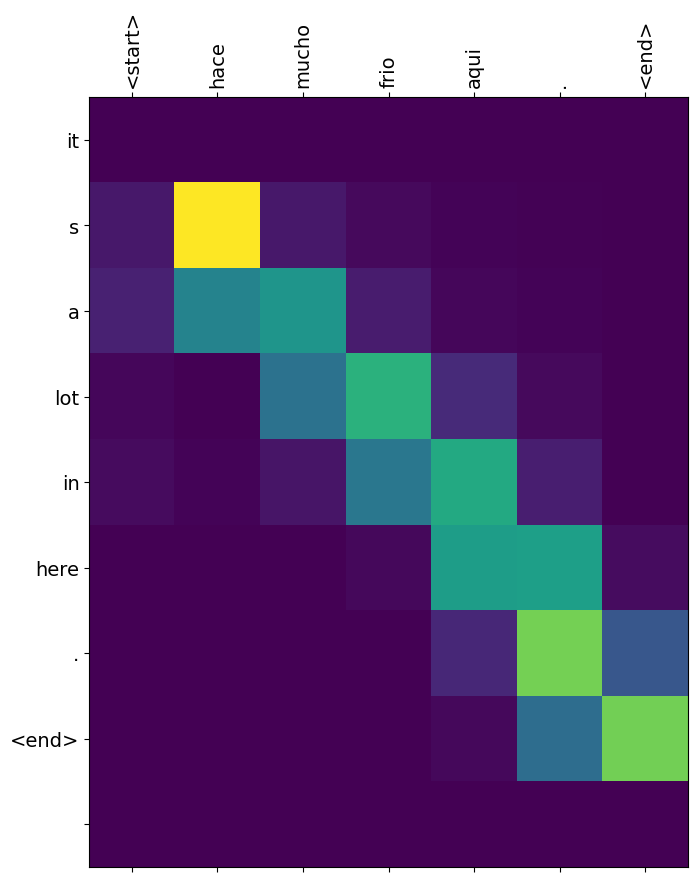

In [28]:
translate('hace mucho frio aqui.')

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


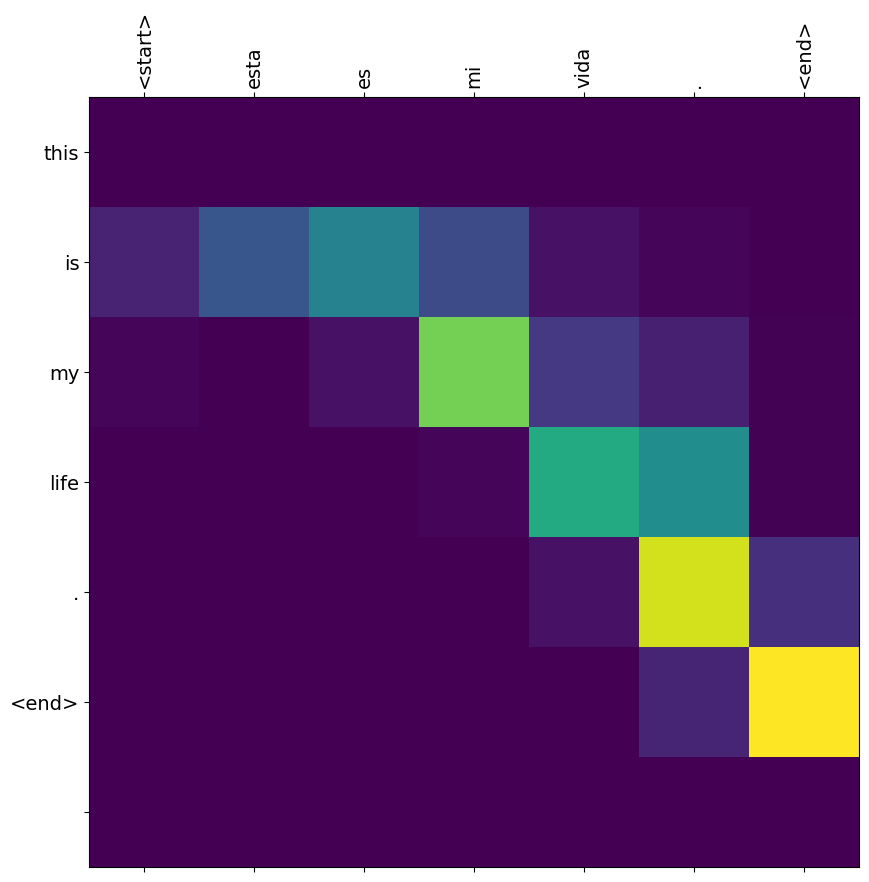

In [29]:
translate('esta es mi vida.')

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you still at home ? <end> 


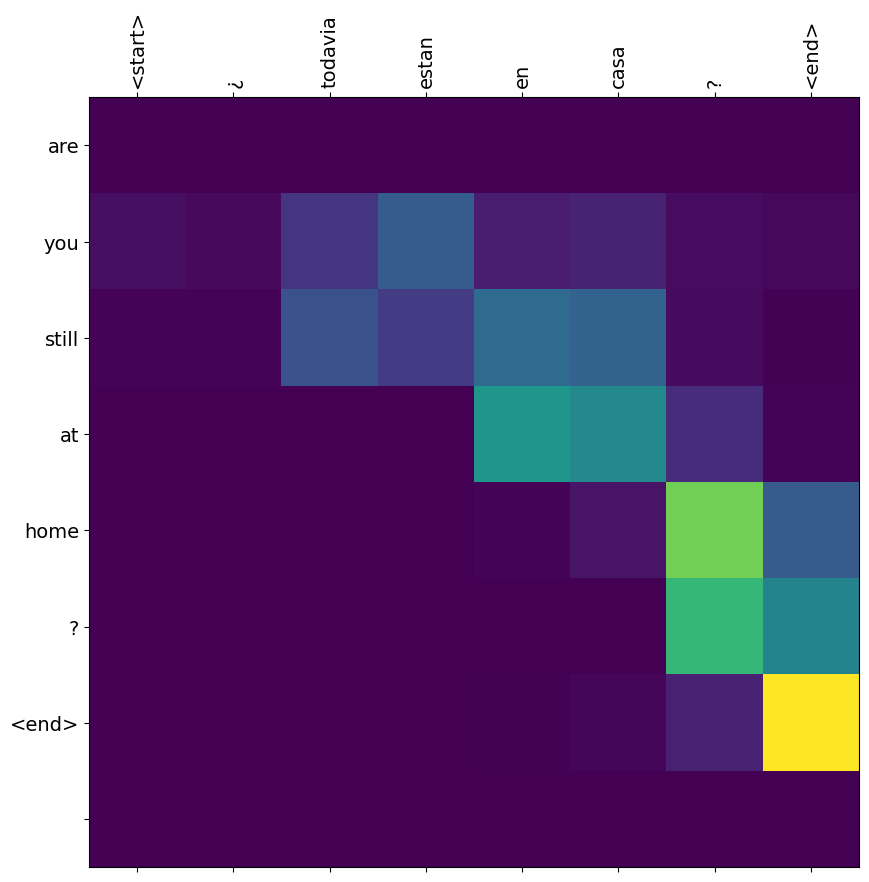

In [30]:
translate('¿todavia estan en casa?')

Input: <start> trata de averiguarlo . <end>
Predicted translation: he is out to find out . <end> 


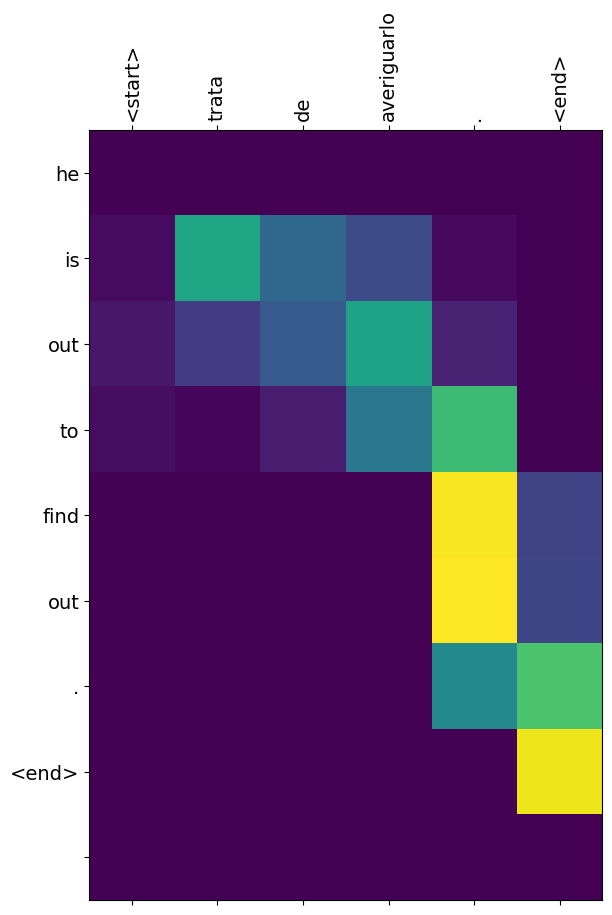

In [31]:
# 잘못된 번역
translate('trata de averiguarlo.')

## 다음 단계

* 앞서 영어-스페인어 데이터셋을 이용해 모델을 훈련하였다. 이제 영어-프랑스어, 영어-한국어 등의 [다양한 다른 언어 데이터셋](http://www.manythings.org/anki/)을 활용하여 모델을 훈련시킨다.
* 또한 이 예제에서는 데이터셋을 제한하여 모델을 만들었다. 이제 더 많은 데이터셋 혹은 더 많은 에포크(epochs)를 적용하여 모델을 훈련한다.

In [32]:
path_to_file = './kor-eng/kor.txt'

In [33]:
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower())
    w = re.sub(r'([?.!,¿])', r' \1 ', w)
    w = re.sub(r'[^\w?.!,¿]+', ' ', w)
    w = w.strip()
    w = '<start> ' + w + ' <end>'
    return w

In [34]:
ko_sentence = '이 책을 빌릴 수 있습니까?'
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(ko_sentence))

<start> may i borrow this book ? <end>
<start> 이 책을 빌릴 수 있습니까 ? <end>


In [35]:
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:-1]] for l in lines[:num_examples]]
    return zip(*word_pairs)

In [36]:
en, ko = create_dataset(path_to_file, None)
print(en[-1])
print(ko[-1])

<start> doubtless there exists in this world precisely the right woman for any given man to marry and vice versa but when you consider that a human being has the opportunity of being acquainted with only a few hundred people , and out of the few hundred that there are but a dozen or less whom he knows intimately , and out of the dozen , one or two friends at most , it will easily be seen , when we remember the number of millions who inhabit this world , that probably , since the earth was created , the right man has never yet met the right woman . <end>
<start> 의심의 여지 없이 세상에는 어떤 남자이든 정확히 딱 알맞는 여자와 결혼하거나 그 반대의 상황이 존재하지 . 그런데 인간이 수백 명의 사람만 알고 지내는 사이가 될 기회를 갖는다고 생각해 보면 , 또 그 수백 명 중 열여 명 쯤 이하만 잘 알 수 있고 , 그리고 나서 그 열여 명 중에 한두 명만 친구가 될 수 있다면 , 그리고 또 만일 우리가 이 세상에 살고 있는 수백만 명의 사람들만 기억

In [37]:
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file)
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [38]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(
    input_tensor, target_tensor, test_size=0.2
)
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

4599 4599 1150 1150


In [39]:
print('Input Language; index to word mapping')
convert(inp_lang, input_tensor_train[0])
print('\nTarget Language; index to word mapping')
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
10 ----> 그
1357 ----> 소년은
4868 ----> 다리에서
1832 ----> 추락했다
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
9 ----> the
478 ----> boy
464 ----> fell
88 ----> from
9 ----> the
1532 ----> bridge
3 ----> .
2 ----> <end>


In [40]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 12  # 64
steps_per_epoch = len(input_tensor_train) // BATCH_SIZE
vocab_inp_size = len(inp_lang.word_index) + 1
vocab_tar_size = len(targ_lang.word_index) + 1
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, True)

In [41]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([12, 97]), TensorShape([12, 112]))

In [42]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print(f'Encoder output shape: (batch size, sequence length, units) {sample_output.shape}')
print(f'Encoder Hidden state shape: (batch size, units) {sample_hidden.shape}')

Encoder output shape: (batch size, sequence length, units) (12, 97, 1024)
Encoder Hidden state shape: (batch size, units) (12, 1024)


In [43]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)
print(f'Attention result shape: (batch size, units) {attention_result.shape}')
print(f'Attention weights shape: (batch_size, sequence_length, 1) {attention_weights.shape}')

Attention result shape: (batch size, units) (12, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (12, 97, 1)


In [44]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_output)
print(f'Decoder output shape: (batch_size, vocab size) {sample_decoder_output.shape}')

Decoder output shape: (batch_size, vocab size) (12, 3110)


In [45]:
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

In [46]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
        for t in range(1, targ.shape[1]):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [47]:
EPOCHS = 10
for epoch in range(EPOCHS):
    start = time.time()
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    for batch, (inp, targ) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss
        if batch % 100 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {batch_loss.numpy():.4f}')
    if (epoch + 1) % 2 == 0:
        checkpoint.save(checkpoint_prefix)
    print(f'Epoch {epoch + 1} Loss {total_loss / steps_per_epoch:.4f}')
    print(f'Time taken for 1 epoch {time.time() - start} sec\n')

Epoch 1 Batch 0 Loss 0.6103
Epoch 1 Batch 100 Loss 0.3542
Epoch 1 Batch 200 Loss 0.2701
Epoch 1 Batch 300 Loss 0.3195
Epoch 1 Loss 0.3335
Time taken for 1 epoch 392.6793510913849 sec

Epoch 2 Batch 0 Loss 0.3259
Epoch 2 Batch 100 Loss 0.2653
Epoch 2 Batch 200 Loss 0.2703
Epoch 2 Batch 300 Loss 0.2968
Epoch 2 Loss 0.2877
Time taken for 1 epoch 271.3570191860199 sec

Epoch 3 Batch 0 Loss 0.2390
Epoch 3 Batch 100 Loss 0.2442
Epoch 3 Batch 200 Loss 0.2584
Epoch 3 Batch 300 Loss 0.2674
Epoch 3 Loss 0.2697
Time taken for 1 epoch 269.51134395599365 sec

Epoch 4 Batch 0 Loss 0.2494
Epoch 4 Batch 100 Loss 0.2245
Epoch 4 Batch 200 Loss 0.2290
Epoch 4 Batch 300 Loss 0.2498
Epoch 4 Loss 0.2525
Time taken for 1 epoch 270.3233835697174 sec

Epoch 5 Batch 0 Loss 0.2402
Epoch 5 Batch 100 Loss 0.2738
Epoch 5 Batch 200 Loss 0.2557
Epoch 5 Batch 300 Loss 0.1870
Epoch 5 Loss 0.2374
Time taken for 1 epoch 269.4151494503021 sec

Epoch 6 Batch 0 Loss 0.2198
Epoch 6 Batch 100 Loss 0.2718
Epoch 6 Batch 200 Los

In [48]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [49]:
BUFFER_SIZE_VAL = len(input_tensor_val)
steps_per_epoch_val = len(input_tensor_val) // BATCH_SIZE
dataset_val = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(BUFFER_SIZE_VAL)
dataset_val = dataset_val.batch(BATCH_SIZE, True)

In [50]:
@tf.function
def evaluate_step(inp, targ, enc_hidden):
    loss = 0
    enc_output, enc_hidden = encoder(inp, enc_hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
    for t in range(1, targ.shape[1]):
        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
        loss += loss_function(targ[:, t], predictions)
        dec_input = tf.expand_dims(targ[:, t], 1)
    batch_loss = (loss / int(targ.shape[1]))
    return batch_loss

In [51]:
start = time.time()
enc_hidden = encoder.initialize_hidden_state()
total_loss = 0
for batch, (inp, targ) in enumerate(dataset_val.take(steps_per_epoch_val)):
    batch_loss = evaluate_step(inp, targ, enc_hidden)
    total_loss += batch_loss
    if batch % 100 == 0:
        print(f'Batch {batch} Loss {batch_loss.numpy():.4f}')
print(f'Loss {total_loss / steps_per_epoch_val:.4f}')
print(f'Time taken {time.time() - start} sec')

Batch 0 Loss 0.2747
Loss 0.2870
Time taken 63.255008935928345 sec


In [52]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    fontdict = {'fontsize': 14, 'name': 'GULIM'}
    ax.set_xticks(np.arange(len(sentence)), [unicodedata.normalize('NFC', s) for s in sentence], **fontdict, rotation=90)
    ax.set_yticks(np.arange(len(predicted_sentence)), predicted_sentence, **fontdict)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

Input: <start> 톰을 제외한 가족 구성원들 전부 프랑스어를 할 수 있어요 . <end>
Predicted translation: you ever a lot of tom . <end> 


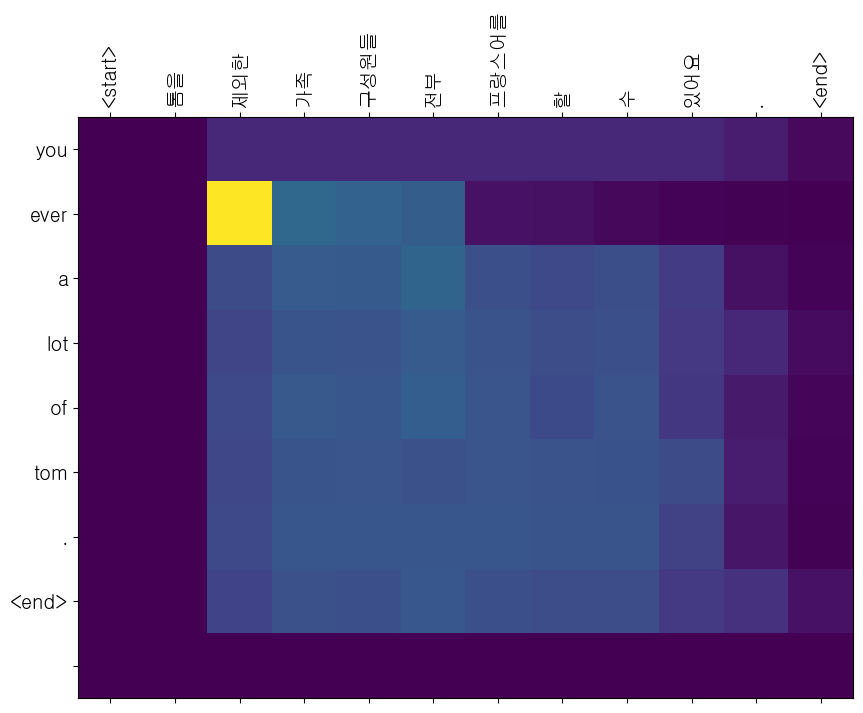

In [53]:
translate('톰을 제외한 가족 구성원들 전부 프랑스어를 할 수 있어요.')